<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Tabnet-as-event-encoder" data-toc-modified-id="Tabnet-as-event-encoder-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Tabnet as event encoder</a></span></li><li><span><a href="#Tabnet-on-handmade-features" data-toc-modified-id="Tabnet-on-handmade-features-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Tabnet on handmade features</a></span></li></ul></div>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

sns.set_style("whitegrid", {'axes.grid' : False})

from tqdm.auto import tqdm

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import torch
torch.cuda.is_available()

True

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [19]:
from pytorch_metric_learning import losses, miners, distances, reducers, samplers
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch.nn as nn
import random

In [66]:
from code.dataloader import AgeGroupMLDataset, AgeGroupClfDataset
from code.encoder_tabnet import Encoder
from code.decoder import Decoder
from code.classifier import Classifier
from code.utils import train_ml_model, train_classifier

In [62]:
BATCH_SIZE = 64 # BATCH_SIZE unique persons
NUM_OF_SUBSEQUENCES = 5
SUBSEQUENCE_LENGTH = 90

EMBEDDING_DIM = 256
LR = 0.002
NUM_EPOCHS = 20

cat_vocab_sizes = [204]
cat_embedding_dim = 20
num_input_dim = 4
NUM_OBS = 30000

In [59]:
arch = 'tabnet'

In [10]:
dataset = AgeGroupMLDataset(num_observations=NUM_OBS)

In [11]:
dataset.load_client_to_indices()

In [12]:
clfdataset = AgeGroupClfDataset()

In [13]:
clfdataset.load_client_to_indices()

In [14]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [60]:
targets = dataset.targets

dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE,
    num_workers=0,
)

targets = clfdataset.targets

train_idx, test_idx= train_test_split(
    np.arange(len(targets)),
    test_size=0.3,
    shuffle=True,
    stratify=targets,
    random_state=228
)

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

trainloader = torch.utils.data.DataLoader(
    clfdataset, batch_size=BATCH_SIZE,
    sampler=train_sampler)
testloader = torch.utils.data.DataLoader(
    clfdataset, batch_size=BATCH_SIZE,
    sampler=test_sampler)

## Tabnet as event encoder

In [67]:
LR = 0.002

# train decoder

encoder = Encoder(
    numerical_input_dim=num_input_dim,
    cat_vocab_sizes=cat_vocab_sizes,
    cat_embedding_dim=cat_embedding_dim,
    embedding_dim=EMBEDDING_DIM,
)
encoder.to(device);
optimizer = optim.Adam(encoder.parameters(), lr=LR)

distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low = 0) # basically, returns average
loss_func = losses.TripletMarginLoss(margin = 0.4, distance = distance, reducer = reducer)
mining_func = miners.TripletMarginMiner(margin = 0.4, distance = distance, type_of_triplets = "semihard")

In [68]:
train_losses = train_ml_model(
    encoder, NUM_EPOCHS, dataloader, NUM_OF_SUBSEQUENCES,
    mining_func, loss_func, optimizer)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0 Loss = 0.2163325846195221
Epoch 1 Loss = 0.18846341967582703
Epoch 2 Loss = 0.17344476282596588
Epoch 3 Loss = 0.16134488582611084
Epoch 4 Loss = 0.1541159451007843
Epoch 5 Loss = 0.1512359380722046
Epoch 6 Loss = 0.14952608942985535
Epoch 7 Loss = 0.14822766184806824
Epoch 8 Loss = 0.1467020958662033
Epoch 9 Loss = 0.14573177695274353
Epoch 10 Loss = 0.14465147256851196
Epoch 11 Loss = 0.14360611140727997
Epoch 12 Loss = 0.14282843470573425
Epoch 13 Loss = 0.14175066351890564
Epoch 14 Loss = 0.14066608250141144
Epoch 15 Loss = 0.14006993174552917
Epoch 16 Loss = 0.13930070400238037
Epoch 17 Loss = 0.13842502236366272
Epoch 18 Loss = 0.13770803809165955
Epoch 19 Loss = 0.13709260523319244


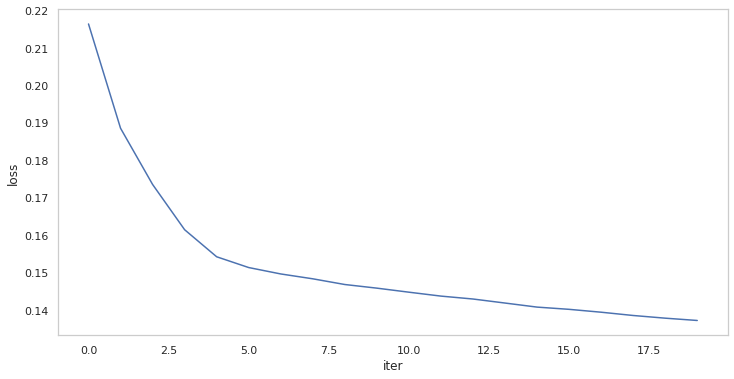

In [69]:
fig, axs = plt.subplots(figsize=(12, 6))

plt.plot(train_losses, label='train')
plt.xlabel('iter')
plt.ylabel('loss');
plt.savefig(f'plots/ML_{arch}_{EMBEDDING_DIM}_{NUM_OBS}_{NUM_EPOCHS}.png')

todo: interpretability from tabnet

In [73]:
NUM_EPOCHS=50

In [74]:
SCHEDULER_EPOCHS = 2
LR = 0.002

# train classifier decoder

classifier = Classifier(
    numerical_input_dim=num_input_dim,
    cat_vocab_sizes=cat_vocab_sizes,
    cat_embedding_dim=cat_embedding_dim,
    embedding_dim=EMBEDDING_DIM
)
classifier.encoder = encoder
classifier.freeze_encoder()
classifier.to(device);

optimizer = optim.Adam(classifier.decoder.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    patience=SCHEDULER_EPOCHS,
)

In [75]:
train_losses, train_accuracy, val_losses, val_accuracy = train_classifier(
    classifier, NUM_EPOCHS, trainloader, testloader,
    optimizer, criterion, scheduler,
    enable_train_mode = lambda: classifier.decoder.train(),
    enable_test_mode = lambda: classifier.decoder.eval(),
)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0, train acc: 0.4433809518814087, val acc: 0.468111127614975
train loss: 1.1992367506027222; val loss: 1.1613271236419678
Epoch 1, train acc: 0.46566665172576904, val acc: 0.47877779603004456
train loss: 1.1651827096939087; val loss: 1.1406508684158325
Epoch 2, train acc: 0.46885713934898376, val acc: 0.4703333377838135
train loss: 1.1602741479873657; val loss: 1.149618148803711
Epoch 3, train acc: 0.4734761714935303, val acc: 0.4757777750492096
train loss: 1.1476926803588867; val loss: 1.1395347118377686
Epoch 4, train acc: 0.47652381658554077, val acc: 0.476666659116745
train loss: 1.1490159034729004; val loss: 1.1519590616226196
Epoch 5, train acc: 0.47890475392341614, val acc: 0.4708888828754425
train loss: 1.1487690210342407; val loss: 1.164040446281433
Epoch 6, train acc: 0.47495236992836, val acc: 0.4856666624546051
train loss: 1.145078182220459; val loss: 1.133867859840393
Epoch 7, train acc: 0.47785714268684387, val acc: 0.4735555648803711
train loss: 1.1437339782714844;

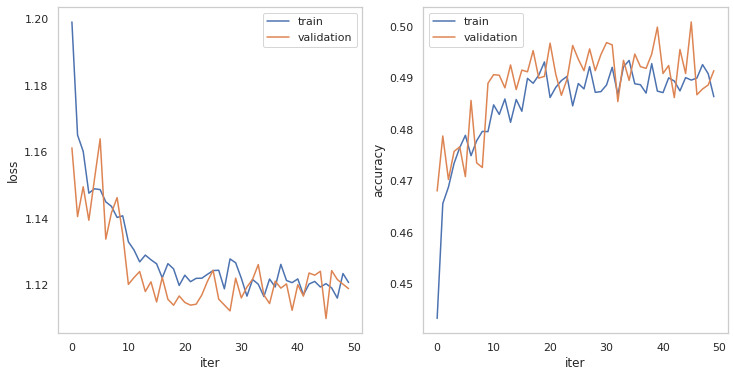

In [76]:
fig, axs = plt.subplots(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='validation')
plt.xlabel('iter')
plt.ylabel('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel('iter')
plt.ylabel('accuracy');
plt.plot(train_accuracy, label='train')
plt.plot(val_accuracy, label='validation')
plt.legend()

plt.savefig(f'plots/clfdec_{arch}_{EMBEDDING_DIM}_{NUM_OBS}_{NUM_EPOCHS}.png')

## Tabnet on handmade features